# CNN 분류

- OX_데이터셋 불러오기
- OX_이미지 전처리
- MLP로 진행시 k-fold 적용, 미적용 각각 정확도 산출

>> sklearn의 model_selection 패키지의 KFold 모듈

In [3]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
import tensorflow as tf

path = 'Dataset/'
# original_size = (300, 300)
resized_area = (128, 128)

x_data = []
labels = []

tf.random.set_seed(42) #랜덤시드 42로 고정


sorted_file = sorted(os.listdir(path))

for fname in sorted_file:
    if not (fname.lower().endswith(".png") or fname.lower().endswith(".jpg")):
        continue
        
    ox = os.path.join(path, fname)
    img = load_img(ox, target_size = resized_area, color_mode = 'grayscale')
    arr = img_to_array(img) #flatten 제거
    x_data.append(arr)

    if fname.lower().startswith("o"):
        labels.append(0)
    elif fname.lower().startswith("x"):
        labels.append(1)
    else:
        print("o,x 아닌 다른 파일이므로 무시.")

x = np.array(x_data) / 255.0 #픽셀 정규화
y = np.array(labels)

x, y = shuffle(x, y, random_state=42) #랜덤시드 42로 고정
print(x.shape, y.shape)
print(np.unique(y, return_counts=True))

print(x.dtype, y.dtype)
print(x.min(), x.max())

(479, 128, 128, 1) (479,)
(array([0, 1]), array([240, 239]))
float32 int64
0.0 1.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Flatten
from sklearn.model_selection import train_test_split
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=777, shuffle=True)
epochs = 6


#배치정규화 - Conv2D - MaxPooling2D로 진행
#Conv2D(filter, kernel_size, strides = None)


K.clear_session()
model = load_model("IMS_CNN.h5")
history = model.fit(x_train, y_train, epochs = epochs, batch_size=16, validation_data = (x_val, y_val), verbose=1, callbacks=[early_stop])
loss, acc = model.evaluate(x_val, y_val, verbose=0)
print(f"모델 정확도(검증 데이터): {acc*100:.2f}%\nloss: {loss:.2f}")

In [20]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Flatten
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

# 검증 손실 감시해서 early stopping 기법
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
val_acc_list = []
train_acc_list = []

epochs = 6

def build_model():
    model = Sequential()
    
    model.add(Conv2D(32, (5,5), activation = "relu", padding="same", kernel_initializer='he_normal', input_shape = (128, 128, 1)))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
              
    model.add(Conv2D(64, (5,5), activation = "relu", padding="same", kernel_initializer='he_normal'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(128, (6,6), activation = "relu", padding="same", kernel_initializer='he_normal'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    model.add(Dropout(0.3))
    model.add(Flatten())

    model.add(Dense(128, activation = "relu", kernel_initializer='he_normal'))
    model.add(Dense(64, activation = "relu", kernel_initializer='he_normal'))
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(1, activation = "sigmoid"))
    model.summary()

    return model


    
for (train_idx, val_idx) in kf.split(x):
    x_train, x_val = x[train_idx], x[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    tf.keras.backend.clear_session()
    model = build_model()
    model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics = ['accuracy'])

    history = model.fit(x_train, y_train, epochs=epochs, batch_size=16, validation_data=(x_val, y_val), callbacks=[early_stop])

    best_epoch = np.argmin(history.history['val_loss']) # val_loss 최솟값인 이포크
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
    
    val_acc_list.append(val_acc)
    train_acc_list.append(history.history['accuracy'][best_epoch])


model.save("IMS_CNN_test.h5")

avg_val_acc = np.mean(val_acc_list) * 100
avg_train_acc = np.mean(train_acc_list) * 100

print(f"모델 평균 정확도(검증 데이터): {avg_val_acc:.2f}%")
print(f"모델 평균 정확도(훈련 데이터): {avg_train_acc:.2f}%")


C:\Users\JSH\anaconda3\envs\AI_CLASS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,551,937 (17.36 MB)

 Trainable params: 4,551,937 (17.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.5469 - loss: 3.4784 - val_accuracy: 0.7812 - val_loss: 0.5724
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.7711 - loss: 0.4723 - val_accuracy: 0.8542 - val_loss: 0.3286
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.8865 - loss: 0.2815 - val_accuracy: 0.8854 - val_loss: 0.2269
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.9165 - loss: 0.1846 - val_accuracy: 0.9375 - val_loss: 0.1705
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.9374 - loss: 0.1283 - val_accuracy: 0.9479 - val_loss: 0.0889
Epoch 6/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.9763 - loss: 0.0741 - val_accuracy: 0.9479 - val_loss: 0.1494


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,551,937 (17.36 MB)

 Trainable params: 4,551,937 (17.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 231ms/step - accuracy: 0.4966 - loss: 2.4046 - val_accuracy: 0.7812 - val_loss: 0.6265
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.7687 - loss: 0.5090 - val_accuracy: 0.8438 - val_loss: 0.3632
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8387 - loss: 0.3433 - val_accuracy: 0.8438 - val_loss: 0.3192
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8590 - loss: 0.2758 - val_accuracy: 0.9479 - val_loss: 0.1622
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.9453 - loss: 0.1619 - val_accuracy: 0.9375 - val_loss: 0.1293
Epoch 6/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9711 - loss: 0.0934 - val_accuracy: 0.9583 - val_loss: 0.1257


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,551,937 (17.36 MB)

 Trainable params: 4,551,937 (17.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.5144 - loss: 4.2468 - val_accuracy: 0.5938 - val_loss: 0.6140
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.6848 - loss: 0.5518 - val_accuracy: 0.8125 - val_loss: 0.3706
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.8658 - loss: 0.3075 - val_accuracy: 0.8229 - val_loss: 0.2870
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.9164 - loss: 0.1872 - val_accuracy: 0.8750 - val_loss: 0.2184
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.9549 - loss: 0.0984 - val_accuracy: 0.8958 - val_loss: 0.2010
Epoch 6/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.9803 - loss: 0.0458 - val_accuracy: 0.8958 - val_loss: 0.2120


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,551,937 (17.36 MB)

 Trainable params: 4,551,937 (17.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step - accuracy: 0.5340 - loss: 1.3577 - val_accuracy: 0.7396 - val_loss: 0.5360
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.8511 - loss: 0.3613 - val_accuracy: 0.8854 - val_loss: 0.2645
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - accuracy: 0.9337 - loss: 0.1733 - val_accuracy: 0.9062 - val_loss: 0.2275
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.9593 - loss: 0.0767 - val_accuracy: 0.8958 - val_loss: 0.2184
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.9726 - loss: 0.0962 - val_accuracy: 0.9167 - val_loss: 0.1962
Epoch 6/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.9858 - loss: 0.0381 - val_accuracy: 0.9062 - val_loss: 0.1843


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,551,937 (17.36 MB)

 Trainable params: 4,551,937 (17.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 333ms/step - accuracy: 0.5090 - loss: 2.0508 - val_accuracy: 0.7474 - val_loss: 0.5116
Epoch 2/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.8047 - loss: 0.3867 - val_accuracy: 0.8526 - val_loss: 0.3292
Epoch 3/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - accuracy: 0.8769 - loss: 0.2448 - val_accuracy: 0.9263 - val_loss: 0.1918
Epoch 4/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.9267 - loss: 0.1390 - val_accuracy: 0.9368 - val_loss: 0.1444
Epoch 5/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.9603 - loss: 0.0758 - val_accuracy: 0.9158 - val_loss: 0.2800
Epoch 6/6
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.9870 - loss: 0.0439 - val_accuracy: 0.9158 - val_loss: 0.1997


모델 평균 정확도(검증 데이터): 92.90%
모델 평균 정확도(훈련 데이터): 96.14%


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


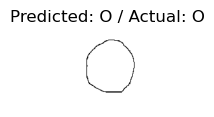

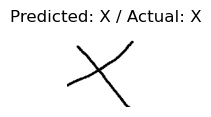

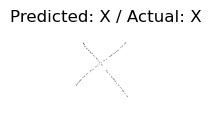

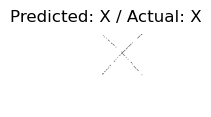

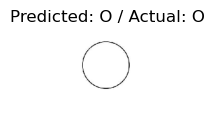

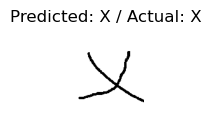

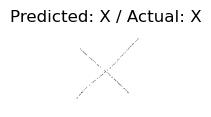

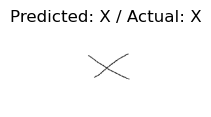

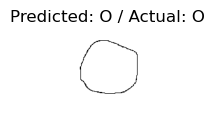

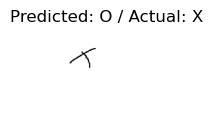

'\nplt.imshow(x[0].reshape(resized_area), cmap=\'gray\')\nplt.title(\'Sample O\')\nplt.show()\n\n# X 이미지 하나\nplt.imshow(x[4].reshape(resized_area), cmap=\'gray\')\nplt.title(\'Sample X\')\nplt.show()\nhistory_dict = history.history\nhistory_dict.keys()\n# 랜덤 시드 42로 고정 \n\nloss = history_dict[\'loss\']\nval_accuracy = history.history[\'val_acc\'uracy\']\ntrain_accuracy = history.history[\'accuracy\']\nplt.plot(range(1, epochs+1), loss, \'go\', label=\'Training loss\')\nplt.title(\'Training Loss\')\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Loss\')\nplt.legend()\nplt.show()\n\nplt.plot(val_accuracy, label="Validation Accuracy")\nplt.plot(train_accuracy, label="Train Accuracy")\n\nplt.title(\'Train & Validation Accuracy\')\nplt.show()\n'

In [17]:
import matplotlib.pyplot as plt
import random as r
%matplotlib inline

y_pred_probs = model.predict(x_val)  # 확률값 나옴
y_pred = (y_pred_probs >= 0.5).astype(int).flatten()  # 0.5 기준으로 이진화(0.5 이상이면 1)


for _ in range(10):
    # 랜덤한 인덱스 선택
    question = r.randint(0, len(x_val) - 1)
    
    # 예측값을 0 또는 1로 변환
    pred_binary = int(y_pred[question] >= 0.5)
    true_binary = int(y_val[question])  # 정답도 int형으로
    
    label_map = {1: 'X', 0: 'O'}
    # 이미지 보여주기
    plt.figure(figsize=(1, 1), dpi = 100)
    plt.imshow(x_val[question].reshape(resized_area), cmap='gray')
    plt.title(f'Predicted: {label_map[pred_binary]} / Actual: {label_map[true_binary]}')
    plt.axis('off')
    plt.show()


'''
plt.imshow(x[0].reshape(resized_area), cmap='gray')
plt.title('Sample O')
plt.show()

# X 이미지 하나
plt.imshow(x[4].reshape(resized_area), cmap='gray')
plt.title('Sample X')
plt.show()
history_dict = history.history
history_dict.keys()
# 랜덤 시드 42로 고정 

loss = history_dict['loss']
val_accuracy = history.history['val_acc'uracy']
train_accuracy = history.history['accuracy']
plt.plot(range(1, epochs+1), loss, 'go', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_accuracy, label="Validation Accuracy")
plt.plot(train_accuracy, label="Train Accuracy")

plt.title('Train & Validation Accuracy')
plt.show()
'''